# Libraries and Helper Functions

In [1]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation

In [2]:
def model_evaluation(X, y, model, label):
    predictions = model.predict(X)
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision_weighted = precision_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} Precision - Weighted: {1:.4f}'.format(label, precision_weighted))
    #calculate recall
    recall_weighted = recall_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} Recall - Weighted: {1:.4f}'.format(label, recall_weighted))
    #calculate f1
    f1_weighted = f1_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} F1 - Weighted: {1:.4f}'.format(label, f1_weighted))    
    cm = confusion_matrix(y, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)
    df_cm = pd.DataFrame(cm, index = sorted(y.unique()), columns = sorted(y.unique()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [35]:
def plot_roc(model_list, model_names, y):
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    for i, model in enumerate(model_list):
        col_names = sorted(y.unique())
        predictions = pd.DataFrame(model[0].predict_proba(model[1]), columns = col_names)
        predictions.to_csv(model_names[i] + '_probabilities.csv', index = False)
        actual = pd.DataFrame({})
        for column in col_names:
            actual[column] = y.apply(lambda y: y == column) 
        fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]], _ = roc_curve(actual.as_matrix().ravel(), predictions.as_matrix().ravel())
        roc_auc["micro - " + model_names[i]] = auc(fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]])
    plt.figure(figsize=(10,10))
    colors = 'bgr'
    for i, color in zip(fpr.keys(), colors):
        plt.plot(fpr[i], tpr[i], color=color, linestyle=':',
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Genre')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def get_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    predictors = X_train.columns
    predictors = [predictors[i] for i in indices]
    predictors_index = range(1, len(predictors) + 1)
    num_features = X_train.shape[1]
    #num_features = len(predictors) if num_features is None else num_features
    plt.figure(figsize=(20,20))
    plt.bar(predictors_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(predictors_index[:num_features], predictors[:num_features], rotation = 'vertical')
    plt.show()

# Load and Clean Data

In [5]:
# load and clean data
train_df = pd.read_csv('../Milestone_4/ihsaan_files/train_w_poster_updated_genres.csv')
test_df = pd.read_csv('../Milestone_4/ihsaan_files/test_w_poster_updated_genres.csv')

In [6]:
print(train_df.shape)
print(test_df.shape)

(8183, 79)
(3495, 79)


In [7]:
X_train = train_df.drop(['genre', 'id', 'poster_path', 'pp'], axis = 1)
y_train = train_df['genre']
X_test = test_df.drop(['genre', 'id', 'poster_path', 'pp'], axis = 1)
y_test = test_df['genre']

# Random Forest

In [8]:
RF_PARAMETERS = {'n_estimators': [500],'max_features' : ['auto', 'sqrt', 'log2'], 'min_samples_leaf' : [1, 10, 100],
'random_state': [42], 'class_weight' : [None, 'balanced', 'balanced_subsample'], 'max_depth': [10, 100, None]}

## Use All Features

### Tune Model

In [11]:
rf_model = RandomForestClassifier()
rf_model_cv = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5)
rf_model_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 0.7170
Train Precision - Weighted: 0.7513
Train Recall - Weighted: 0.7170
Train F1 - Weighted: 0.7178


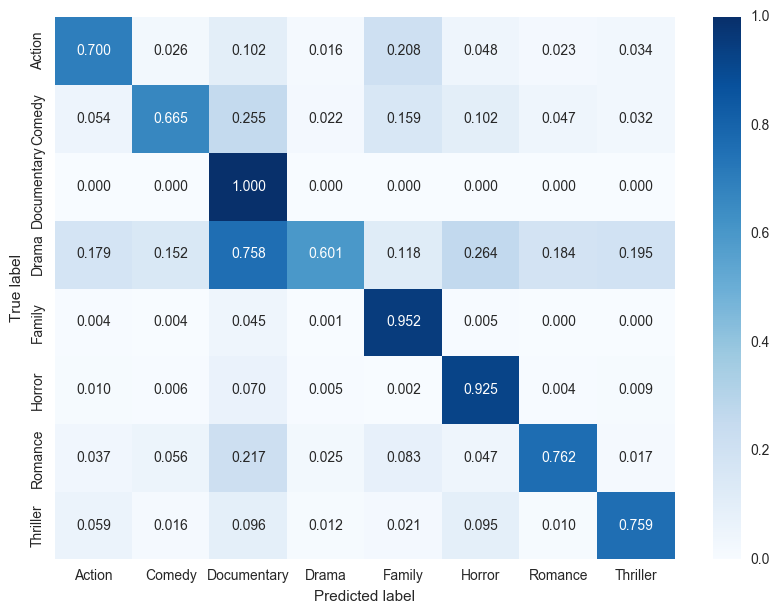

Test Accuracy: 0.4569
Test Precision - Weighted: 0.4842
Test Recall - Weighted: 0.4569
Test F1 - Weighted: 0.4588


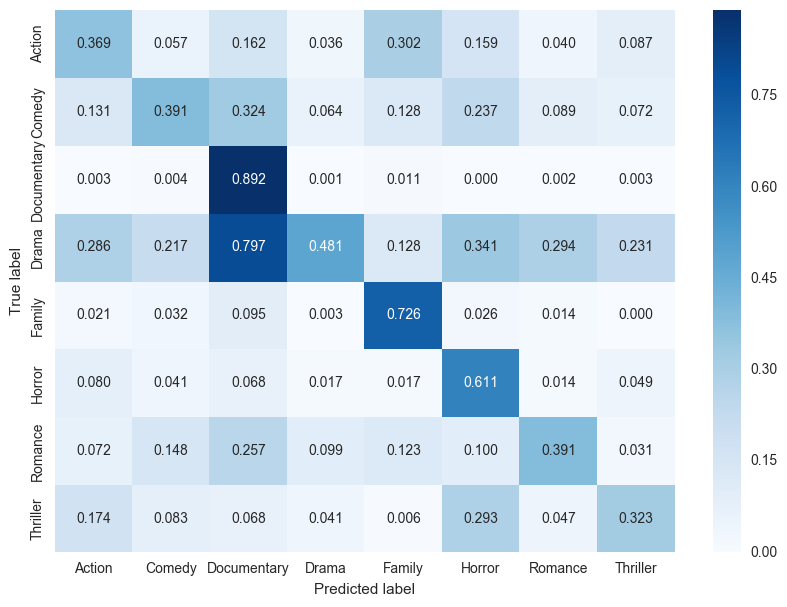

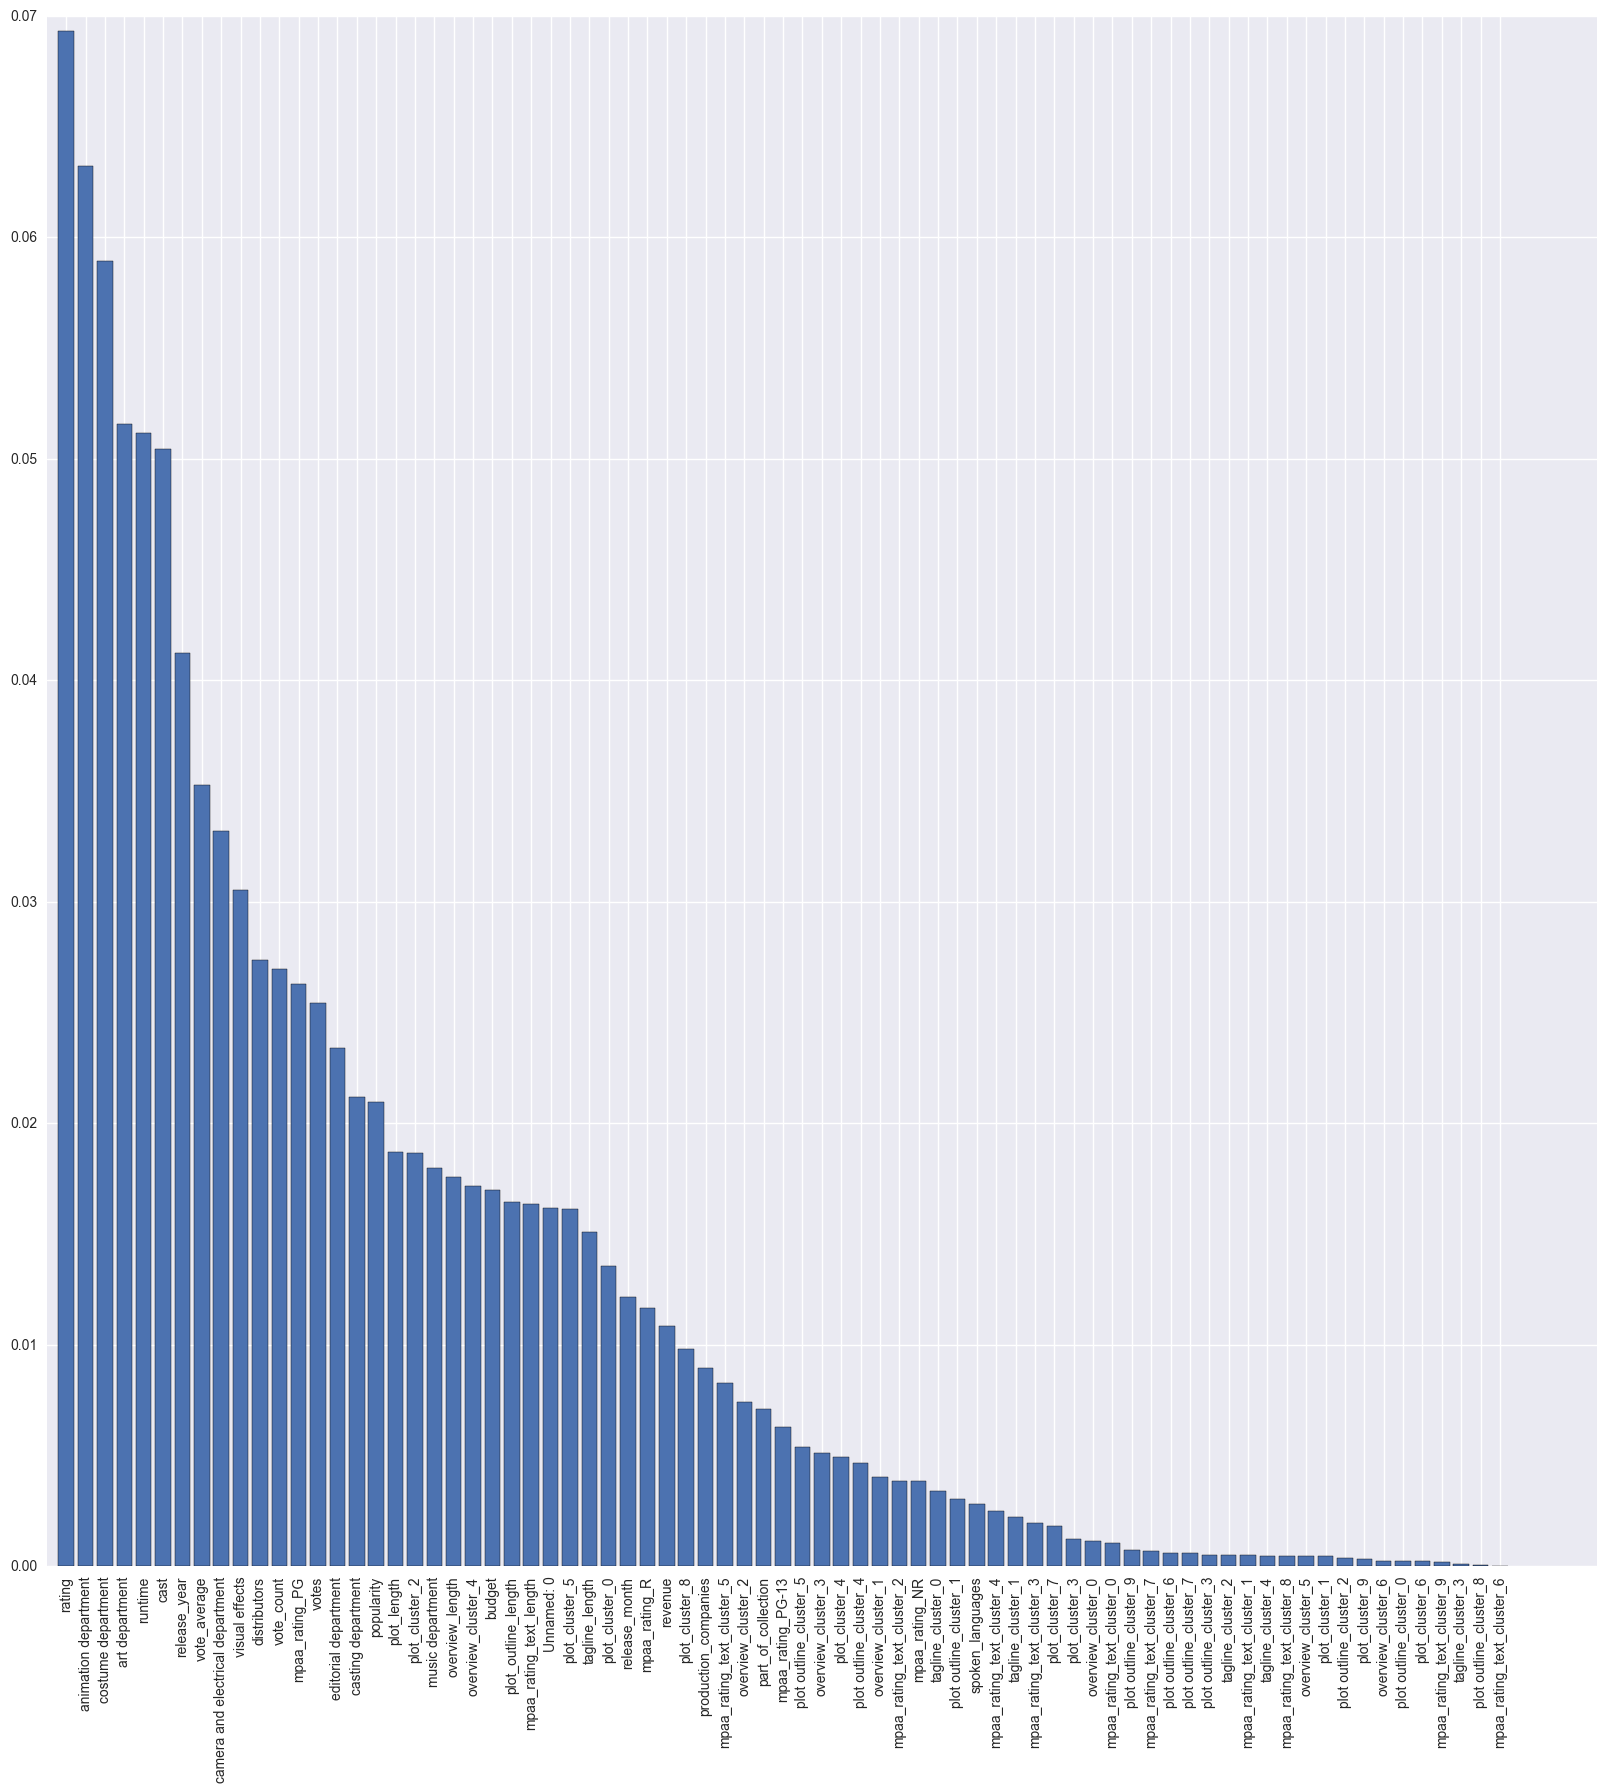

In [12]:
print(rf_model_cv.best_estimator_)
rf_model_chosen = rf_model_cv.best_estimator_
model_evaluation(X_train, y_train, rf_model_chosen, 'Train')
model_evaluation(X_test, y_test, rf_model_chosen, 'Test')
get_feature_importance(rf_model_chosen, X_train)

## Exclude Rating / Clustering

In [13]:
columns_to_include = [column for column in X_train.columns if 'cluster' not in column and 'mpaa_rating' not in column]
X_train_1 = X_train[columns_to_include]
X_test_1 = X_test[columns_to_include]

### Tune Model

In [14]:
rf_model = RandomForestClassifier()
rf_model_cv_1 = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5)
rf_model_cv_1.fit(X_train_1, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 0.7413
Train Precision - Weighted: 0.7727
Train Recall - Weighted: 0.7413
Train F1 - Weighted: 0.7445


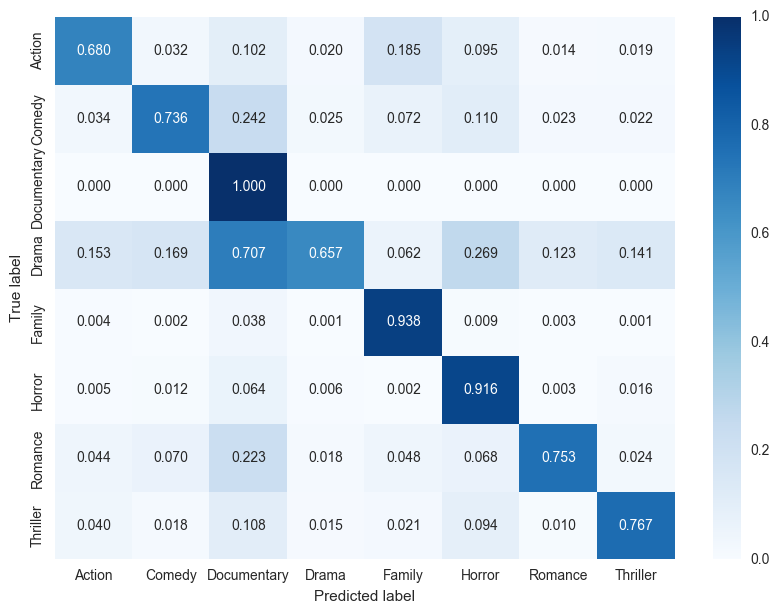

Test Accuracy: 0.4134
Test Precision - Weighted: 0.4330
Test Recall - Weighted: 0.4134
Test F1 - Weighted: 0.4127


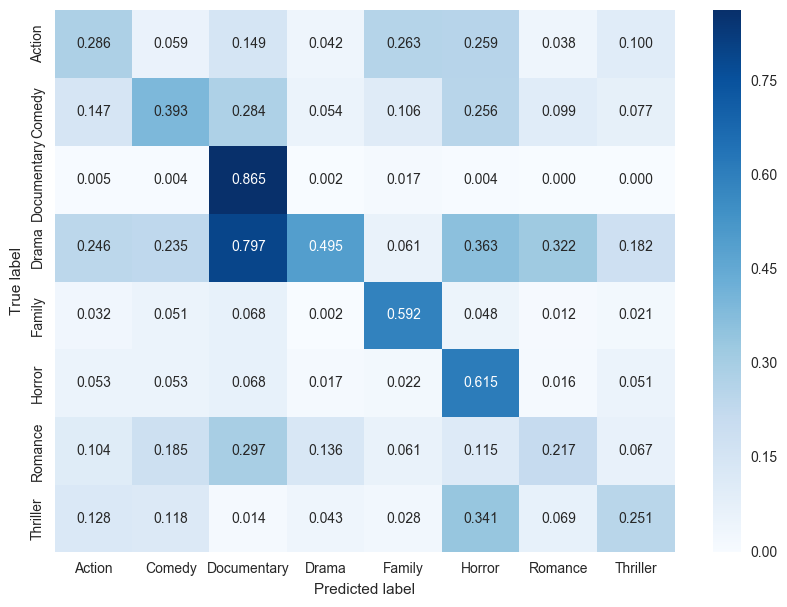

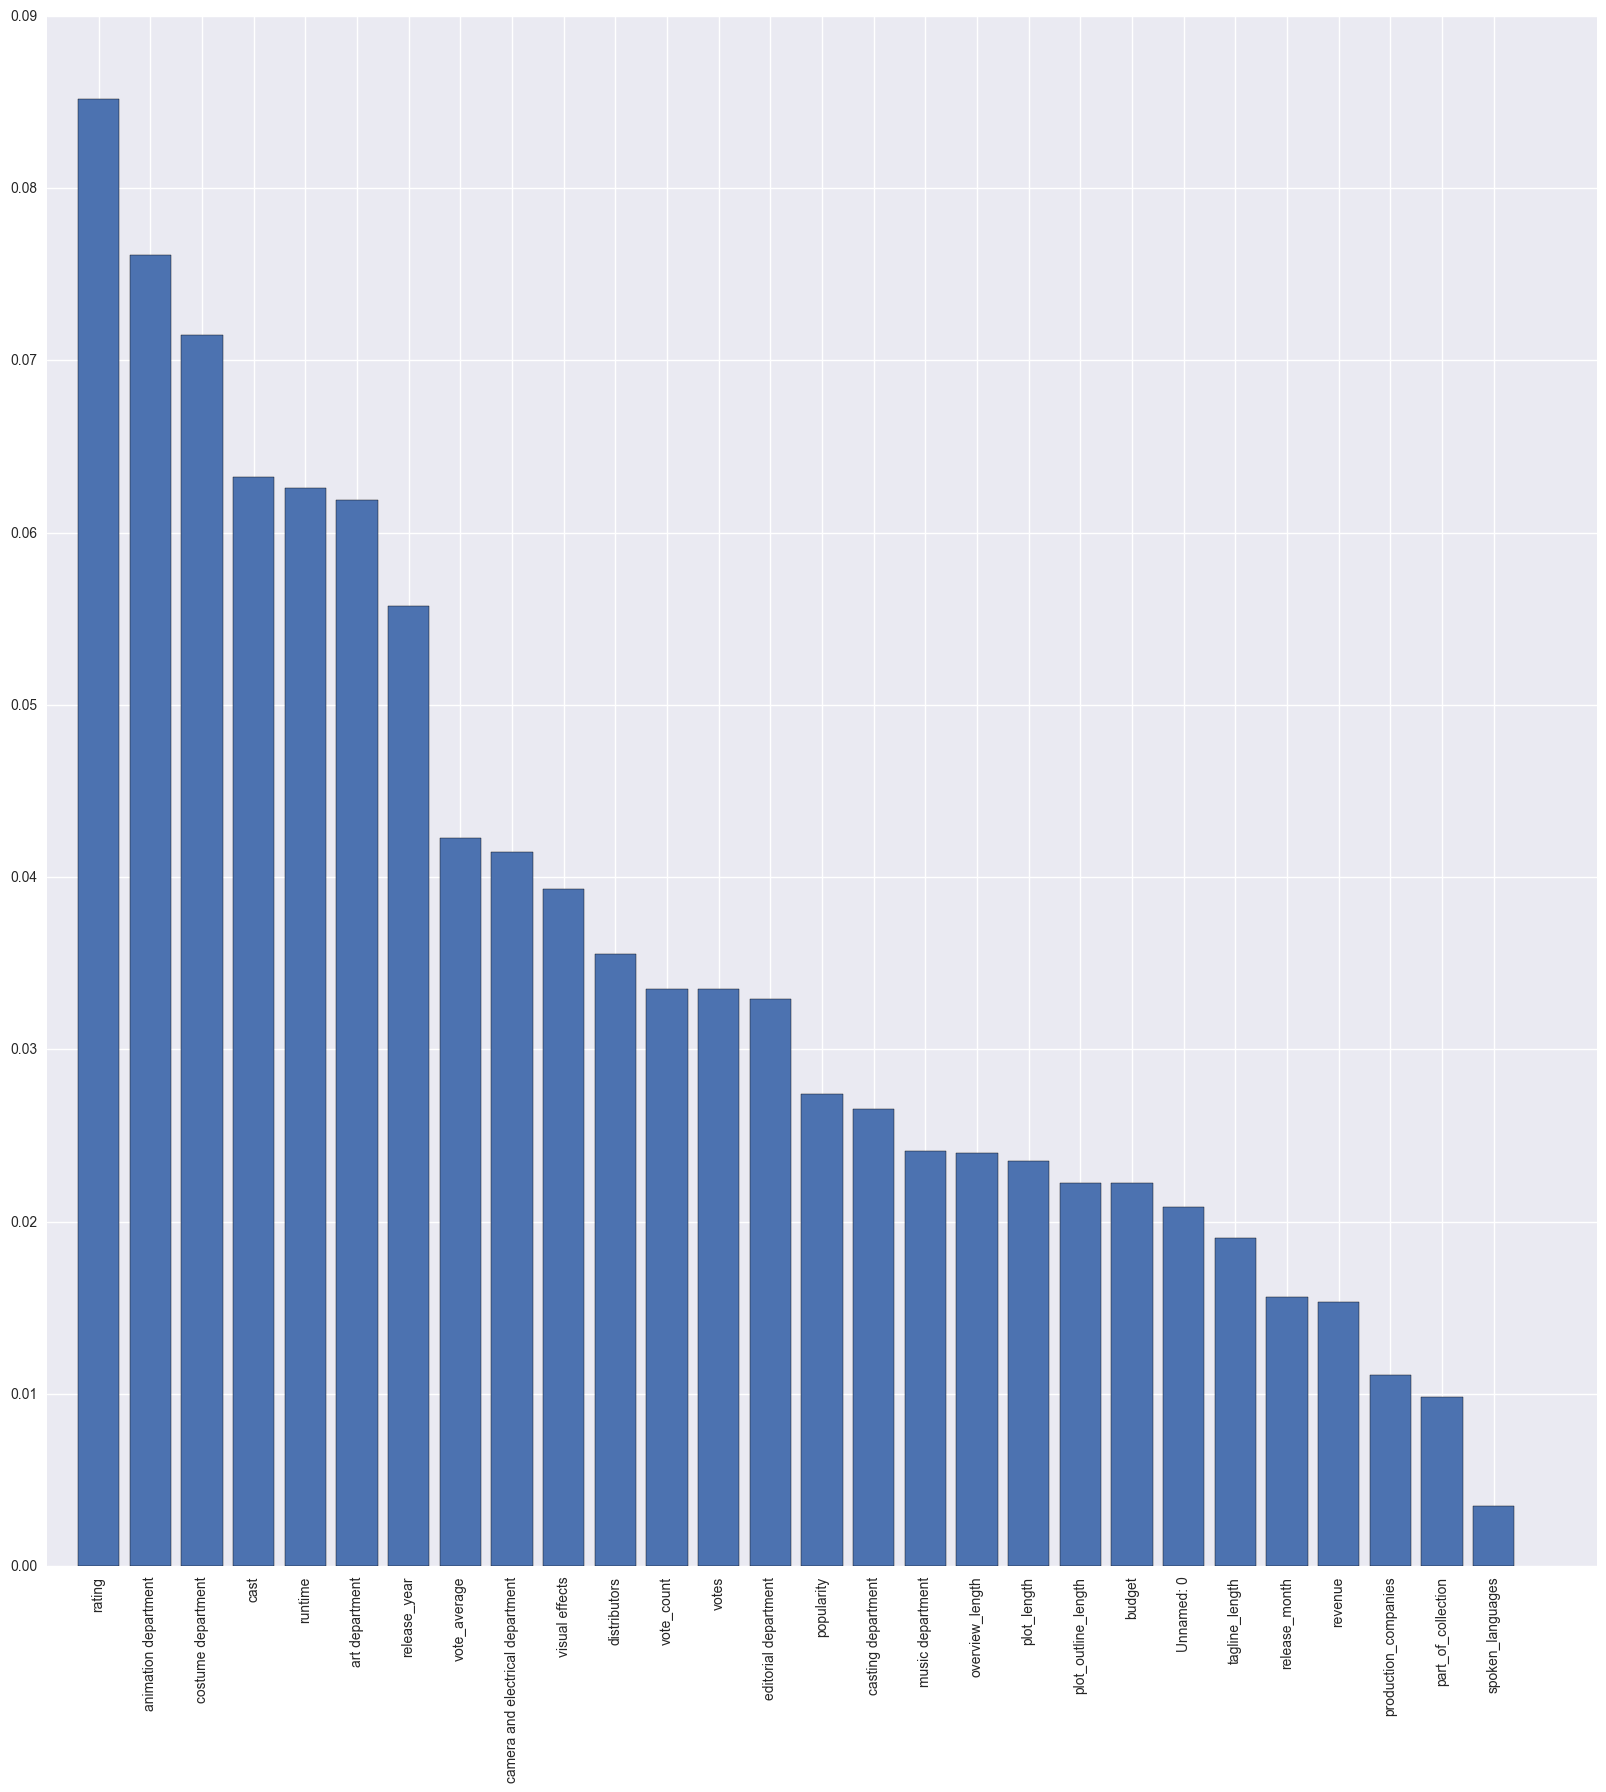

In [15]:
print(rf_model_cv_1.best_estimator_)
rf_model_chosen_1 = rf_model_cv_1.best_estimator_
model_evaluation(X_train_1, y_train, rf_model_chosen_1, 'Train')
model_evaluation(X_test_1, y_test, rf_model_chosen_1, 'Test')
get_feature_importance(rf_model_chosen_1, X_train_1)

## Top 10 Feature Importance

In [16]:
columns_to_include =['rating', 'runtime', 'cast', 'release_year', 'votes', 'vote_average', 'art department', 'popularity',
                'camera and electrical department', 'costume department']
X_train_2 = X_train[columns_to_include]
X_test_2 = X_test[columns_to_include]

### Tune

In [21]:
rf_model = RandomForestClassifier()
rf_model_cv_2 = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5, verbose = 10)
rf_model_cv_2.fit(X_train_2, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.364608 -   5.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    5.1s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.343376 -   4.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.361357 -   4.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.360295 -   5.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   19.9s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.365786 -   5.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.362230 -   4.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.340113 -   4.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:   34.0s


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.356559 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.366530 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.364745 -   4.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.282590 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:   53.0s


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.280543 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.288222 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.272996 -   3.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.364608 -   5.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:  1.2min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.361357 -   5.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.360295 -   5.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.365786 -   5.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.362230 -   4.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:  1.8min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.364745 -   4.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.282590 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.262901 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.280543 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_we

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.2min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.343376 -   5.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.361357 -   5.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.360295 -   5.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.365786 -   5.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  2.9min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.282590 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.262901 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.280543 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.288222 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_w

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.7min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.382649 -   7.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.376486 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.351178 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.367757 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_we

[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:  4.5min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.396580 -   7.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.375757 -   8.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.381486 -   7.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.381645 -   7.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=No

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  5.6min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.262901 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.280532 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.288222 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.272996 -   3.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=100, c

[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:  6.7min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.365859 -   4.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.282600 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.262901 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.280532 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, 

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:  7.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.367757 -   5.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.374757 -   5.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.365859 -   5.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.282600 -   3.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=No

[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:  9.3min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.367757 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.374757 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.365859 -   5.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.282600 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=No

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed: 10.7min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.367757 -   5.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.374757 -   5.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.365859 -   5.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.282600 -   3.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=No

[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed: 12.0min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.383393 -   4.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.325544 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.326967 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.319954 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 13.2min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.326967 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.319954 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.335865 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.350653 -   3.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=l

[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed: 14.5min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.391900 -   8.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.375306 -   7.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.376062 -   7.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.363218 -   7.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, ma

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 16.4min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.385262 -   7.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.382274 -   4.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.367358 -   4.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.391107 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=s

[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed: 18.2min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.324230 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.328020 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.323160 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.339446 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_f

[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed: 20.0min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.375306 -   7.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.376062 -   7.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.363218 -   7.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.385262 -   7.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed: 22.3min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.399959 -   5.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.324230 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.328020 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.323160 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42,

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed: 24.1min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.378495 -   5.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.396926 -   5.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.398647 -   5.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.370024 -   5.0s
[CV] min_samples

[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed: 26.1min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.322878 -   4.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.339767 -   4.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.350019 -   4.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample, score=0.390268 -   8.6s
[CV] m

[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed: 28.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.383653 -   6.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.389616 -   6.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.403965 -   6.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.321327 -   4.3s
[C

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 31.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.378060 -   9.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.385353 -   6.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.361655 -   6.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.383653 -   6.5

[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed: 34.7min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.371162 -   7.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.370598 -  55.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.367840 -   8.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.378060 -   8.3s
[CV]

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 39.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=10)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 0.6771
Train Precision - Weighted: 0.7076
Train Recall - Weighted: 0.6771
Train F1 - Weighted: 0.6805


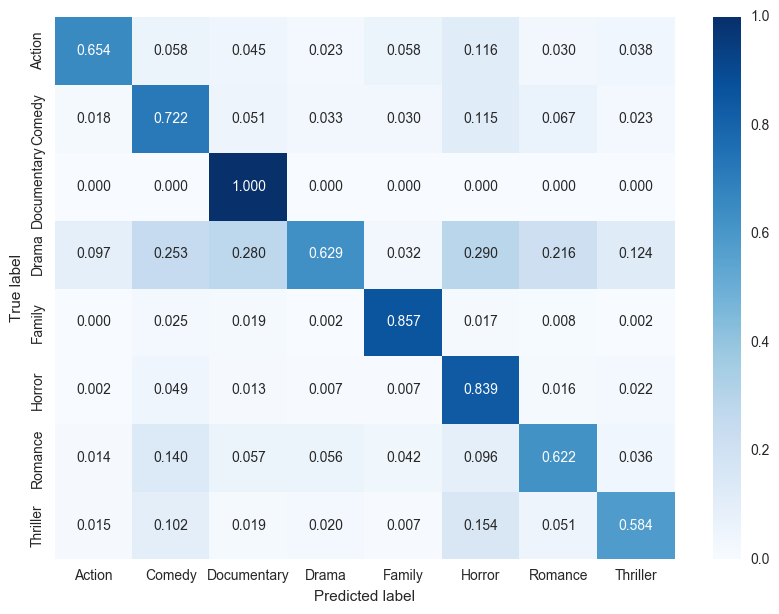

Test Accuracy: 0.3837
Test Precision - Weighted: 0.4071
Test Recall - Weighted: 0.3837
Test F1 - Weighted: 0.3854


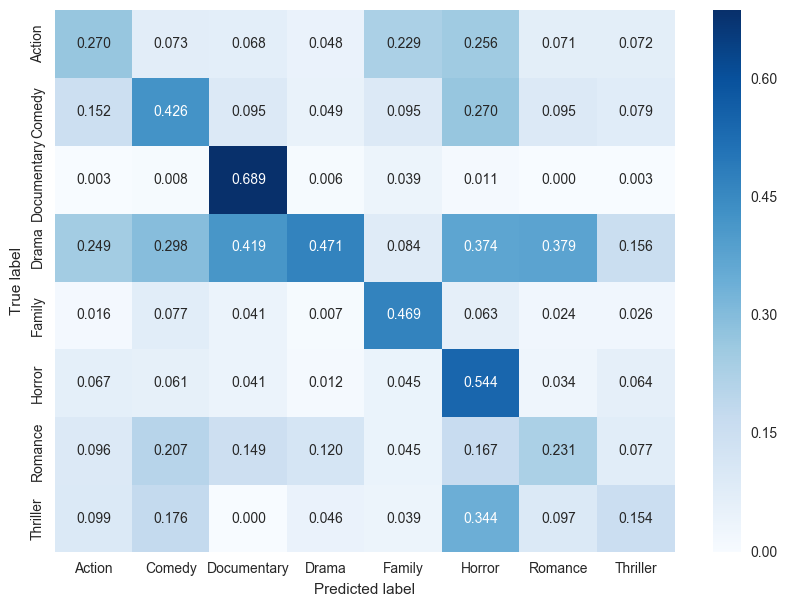

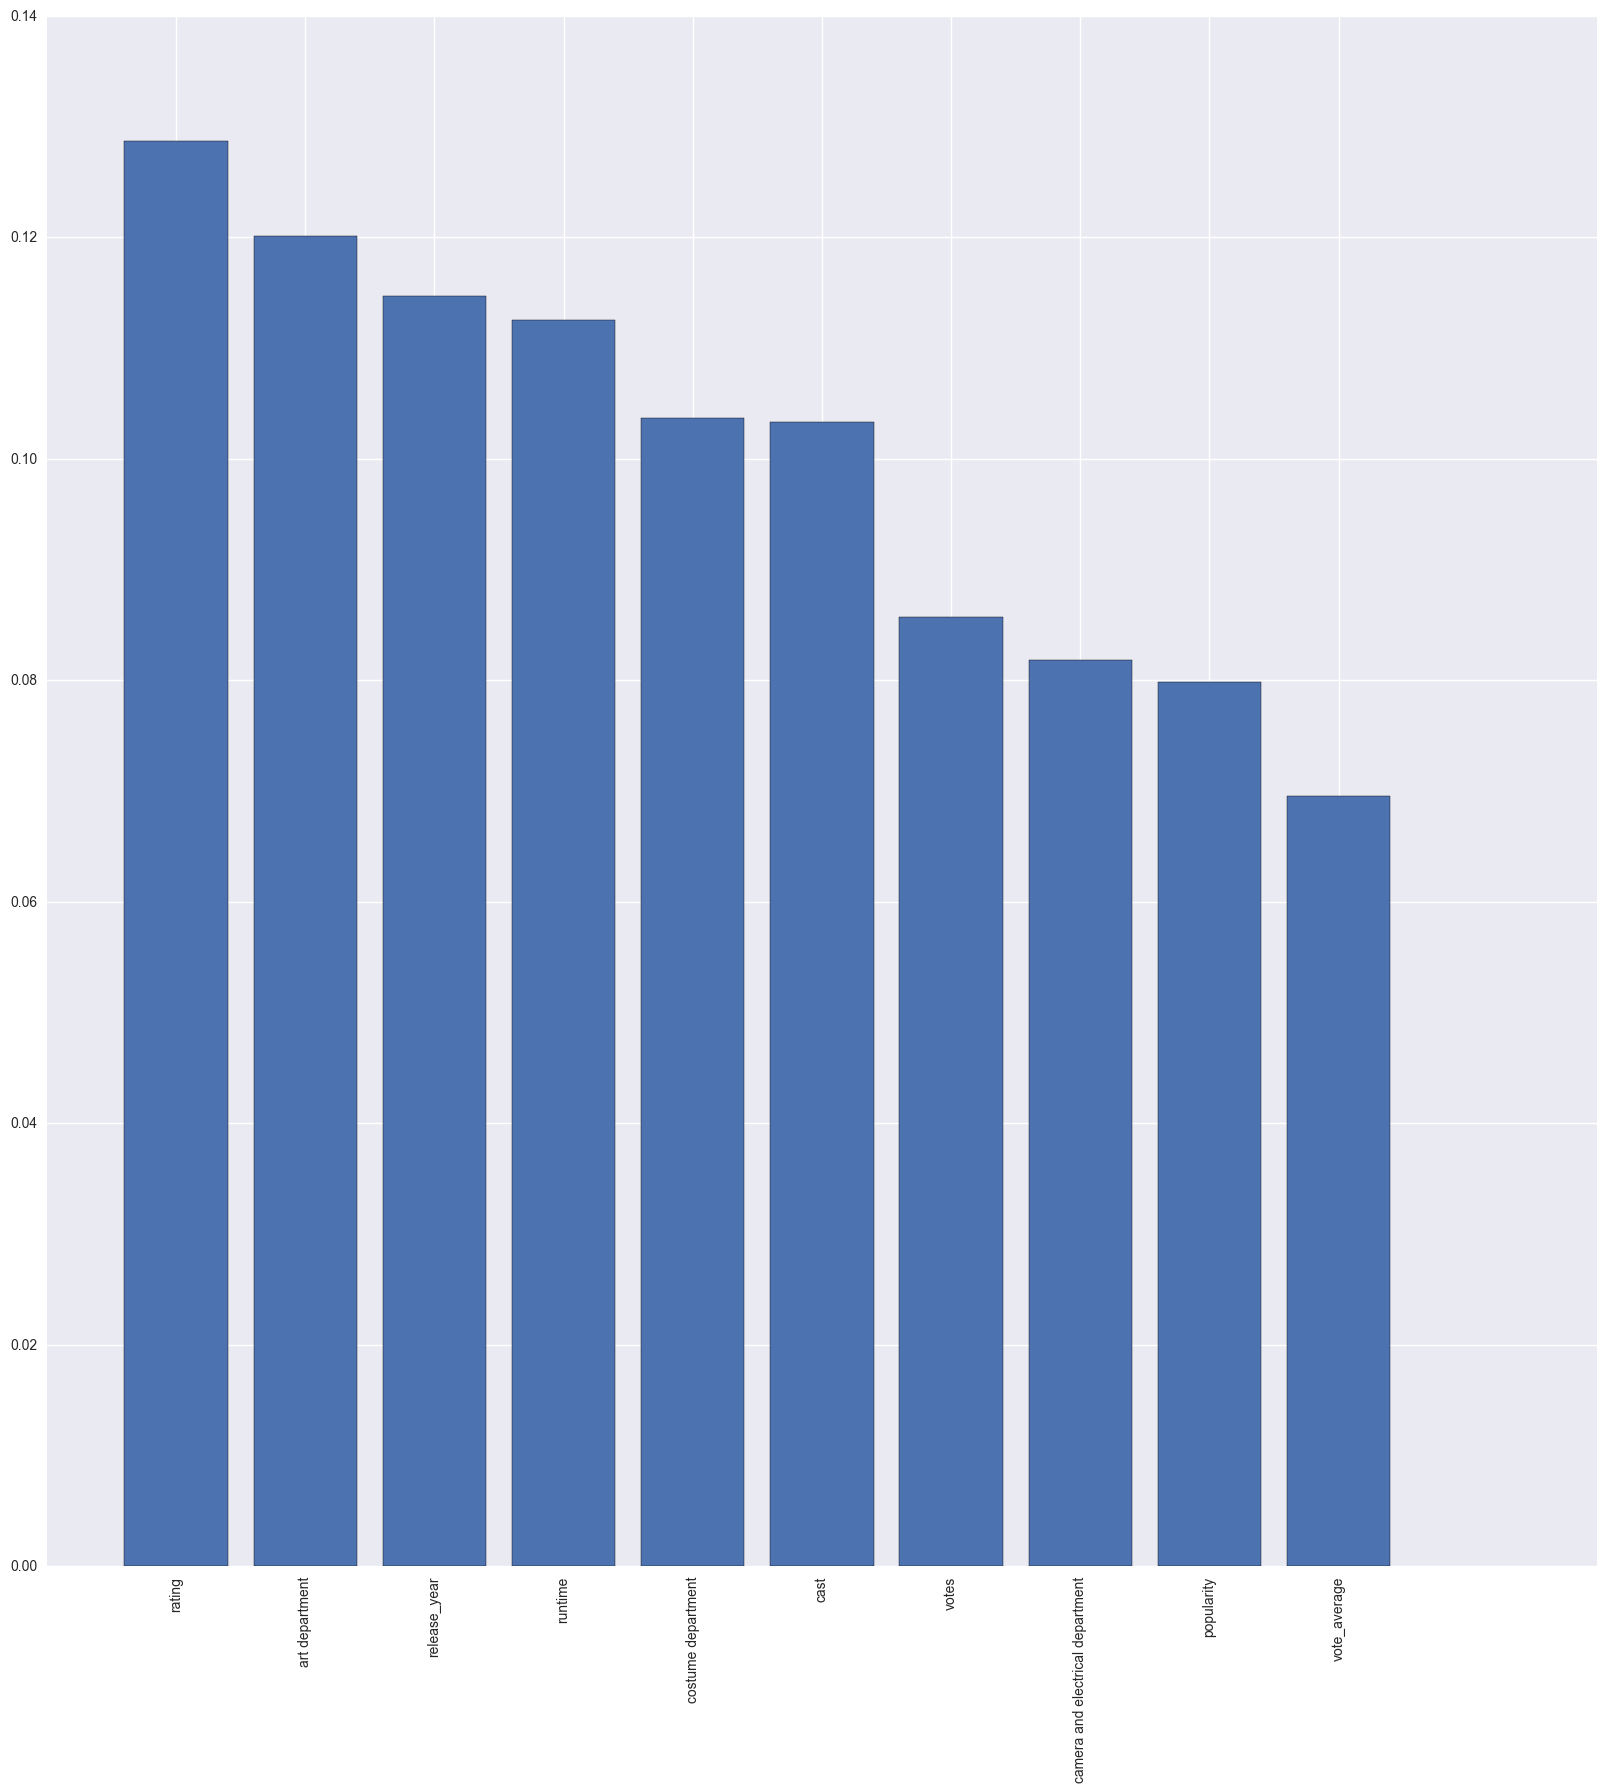

In [22]:
print(rf_model_cv_2.best_estimator_)
rf_model_chosen_2 = rf_model_cv_2.best_estimator_
model_evaluation(X_train_2, y_train, rf_model_chosen_2, 'Train')
model_evaluation(X_test_2, y_test, rf_model_chosen_2, 'Test')
get_feature_importance(rf_model_chosen_2, X_train_2)

# XGBoost

### Default Param Model

In [23]:
xgb_model_1 = XGBClassifier()
xgb_model_1.fit(X_train, y_train)
model_evaluation(X_train, y_train, xgb_model_1, 'Train')

KeyboardInterrupt: 

### First Tune max_depth and min_child_weight

In [24]:
# parameter definitions
'''
max_depth : int
Maximum tree depth for base learners.
learning_rate : float
Boosting learning rate (xgb’s “eta”)
n_estimators : int
Number of boosted trees to fit.
silent : boolean
Whether to print messages while running boosting.
objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
nthread : int
Number of parallel threads used to run xgboost.
gamma : float
Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.
max_delta_step : int
Maximum delta step we allow each tree’s weight estimation to be.
subsample : float
Subsample ratio of the training instance.
colsample_bytree : float
Subsample ratio of columns when constructing each tree.
colsample_bylevel : float
Subsample ratio of columns for each split, in each level.
reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights
scale_pos_weight : float
Balancing of positive and negative weights.
base_score:
The initial prediction score of all instances, global bias.
seed : int
Random number seed.
'''
xgb_model_2 = XGBClassifier()
XGB_PARAMETERS = {'max_depth': range(3,10,2), 'min_child_weight': range(0,6,2)}
xgb_model_2_cv = GridSearchCV(xgb_model_2, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_2_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.061616 -  14.0s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   14.0s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.471008 -  15.5s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   29.5s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.489274 -  13.8s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:   43.3s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.505623 -  13.9s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   57.2s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [0, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=100)

In [25]:
xgb_model_2_cv.grid_scores_, xgb_model_2_cv.best_params_, xgb_model_2_cv.best_score_

([mean: 0.37594, std: 0.16615, params: {'max_depth': 3, 'min_child_weight': 0},
  mean: 0.36598, std: 0.17078, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.36801, std: 0.17206, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.39818, std: 0.16123, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.37208, std: 0.17718, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.36699, std: 0.17584, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.39826, std: 0.15090, params: {'max_depth': 7, 'min_child_weight': 0},
  mean: 0.36158, std: 0.17700, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.36719, std: 0.17704, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.39654, std: 0.13688, params: {'max_depth': 9, 'min_child_weight': 0},
  mean: 0.36323, std: 0.17351, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.37047, std: 0.17525, params: {'max_depth': 9, 'min_child_weight': 4}],
 {'max_depth': 7, 'min_child_weight': 0

### Second: Tune gamma

In [26]:
xgb_model_3 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_2_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'gamma': [i/10.0 for i in range(0,5)]})
print XGB_PARAMETERS
xgb_model_3_cv = GridSearchCV(xgb_model_3, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_3_cv.fit(X_train, y_train)
xgb_model_3_cv.grid_scores_, xgb_model_3_cv.best_params_, xgb_model_3_cv.best_score_

{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'max_depth': [7], 'min_child_weight': [0]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] max_depth=7, gamma=0.0, min_child_weight=0 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=0, score=0.102754 -  26.9s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   26.9s
[CV] max_depth=7, gamma=0.0, min_child_weight=0 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=0, score=0.463897 -  28.7s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   55.5s
[CV] max_depth=7, gamma=0.0, min_child_weight=0 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=0, score=0.495540 -  28.3s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.4min
[CV] max_depth=7, gamma=0.0, min_child_weight=0 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=0, score=0.508904 -  28.5s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:  1.9min
[CV] max_depth=7, gamma=0.0, min

([mean: 0.39826, std: 0.15090, params: {'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.39410, std: 0.14715, params: {'max_depth': 7, 'gamma': 0.1, 'min_child_weight': 0},
  mean: 0.38048, std: 0.15269, params: {'max_depth': 7, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.37385, std: 0.16476, params: {'max_depth': 7, 'gamma': 0.3, 'min_child_weight': 0},
  mean: 0.36958, std: 0.16822, params: {'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 0}],
 {'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 0},
 0.39825965722751977)

### Third: Tune subsample and colsample_bytree

In [27]:
xgb_model_4 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_3_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'subsample':[i/10.0 for i in range(6,10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)]})
xgb_model_4_cv = GridSearchCV(xgb_model_4, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_4_cv.fit(X_train, y_train)
xgb_model_4_cv.grid_scores_, xgb_model_4_cv.best_params_, xgb_model_4_cv.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0, score=0.197902 -  20.8s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   20.8s
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0, score=0.485217 -  20.3s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   41.1s
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0, score=0.499075 -  20.6s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.0min
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child_weight=0 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.0, min_child

([mean: 0.41296, std: 0.11609, params: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.41945, std: 0.11397, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.40934, std: 0.12818, params: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.41149, std: 0.14608, params: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.41666, std: 0.11047, params: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.41709, std: 0.12318, params: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.40582, std: 0.13112, params: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.41088, std: 0.14330, params: {'

### Fourth: Tune regularization params

In [28]:
xgb_model_5 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_4_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[1e-5, 1e-3, 0.1, 1, 10, 100]})
xgb_model_5_cv = GridSearchCV(xgb_model_5, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_5_cv.fit(X_train, y_train)
xgb_model_5_cv.grid_scores_, xgb_model_5_cv.best_params_, xgb_model_5_cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0, score=0.225217 -  27.9s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   27.9s
[CV] reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0, score=0.477976 -  28.3s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   56.2s
[CV] reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0, score=0.503174 -  29.2s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.4min
[CV] reg_alpha=1e-05, colsample_bytree=0.9, min_child_weight=

([mean: 0.42526, std: 0.10532, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.42322, std: 0.11031, params: {'reg_alpha': 0.001, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.42351, std: 0.10026, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.44696, std: 0.07259, params: {'reg_alpha': 1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.49414, std: 0.01485, params: {'reg_alpha': 10, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.27959, std: 0.01001, params: {'reg_alpha': 100, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0}],
 {'colsample_bytree': 0.9,
  'gamma': 0.0,
  'max_depth': 7,
  'min_

In [29]:
xgb_model_6 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_5_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[.01, .05, 0.1, .3, .5, .75]})
xgb_model_6_cv = GridSearchCV(xgb_model_6, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose = 100)
xgb_model_6_cv.fit(X_train, y_train)
xgb_model_6_cv.grid_scores_, xgb_model_6_cv.best_params_, xgb_model_6_cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0, score=0.226888 -  31.3s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   31.3s
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0, score=0.484998 -  28.0s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   59.3s
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=7, gamma=0.0, score=0.498311 -  29.8s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.5min
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subs

([mean: 0.42363, std: 0.10473, params: {'reg_alpha': 0.01, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.41883, std: 0.10951, params: {'reg_alpha': 0.05, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.42351, std: 0.10026, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.42749, std: 0.10290, params: {'reg_alpha': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.43425, std: 0.09103, params: {'reg_alpha': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0},
  mean: 0.44034, std: 0.08852, params: {'reg_alpha': 0.75, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 7, 'gamma': 0.0}],
 {'colsample_bytree': 0.9,
  'gamma': 0.0,
  'max_depth': 7,
  'mi

### Fifth: Reduce Learning Rate, Add More Tree

In [31]:
print xgb_model_6.best_params_

AttributeError: 'XGBClassifier' object has no attribute 'best_params_'

In [32]:
xgb_model_final = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    colsample_bytree = 0.9,
    gamma = 0.0,
    max_depth = 7,
    min_child_weight = 0,
    reg_alpha =0.75,
    subsample = 0.6)
print "here"
xgb_model_final.fit(X_train, y_train, verbose = 100)

here


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=0, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0.75, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Train Accuracy: 1.0000
Train Precision - Weighted: 1.0000
Train Recall - Weighted: 1.0000
Train F1 - Weighted: 1.0000


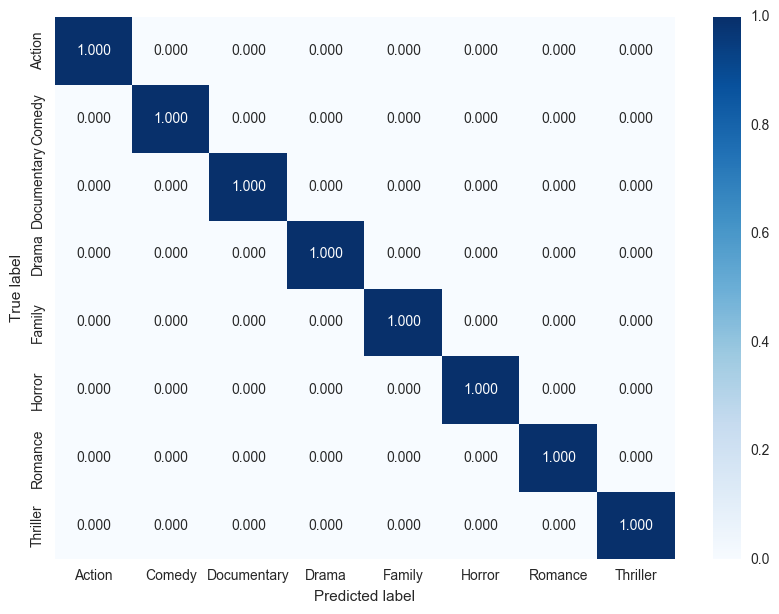

Test Accuracy: 0.5062
Test Precision - Weighted: 0.4936
Test Recall - Weighted: 0.5062
Test F1 - Weighted: 0.4909


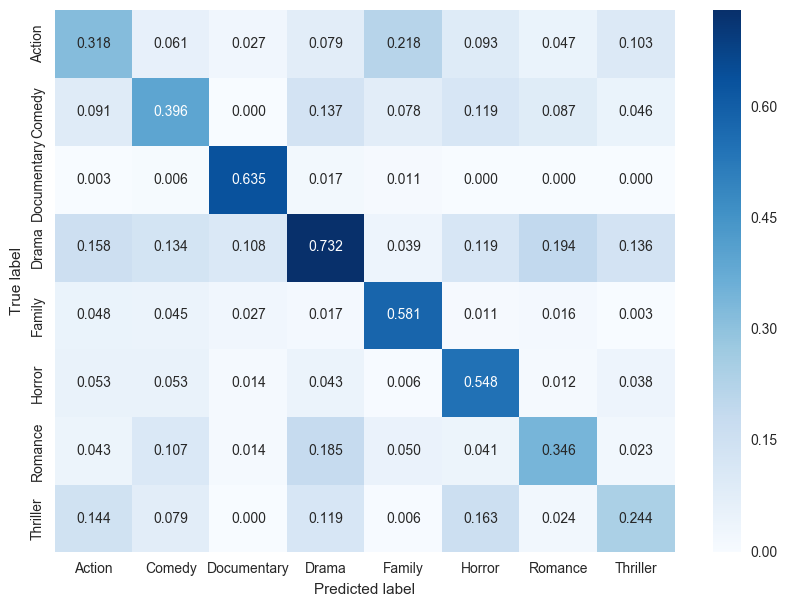

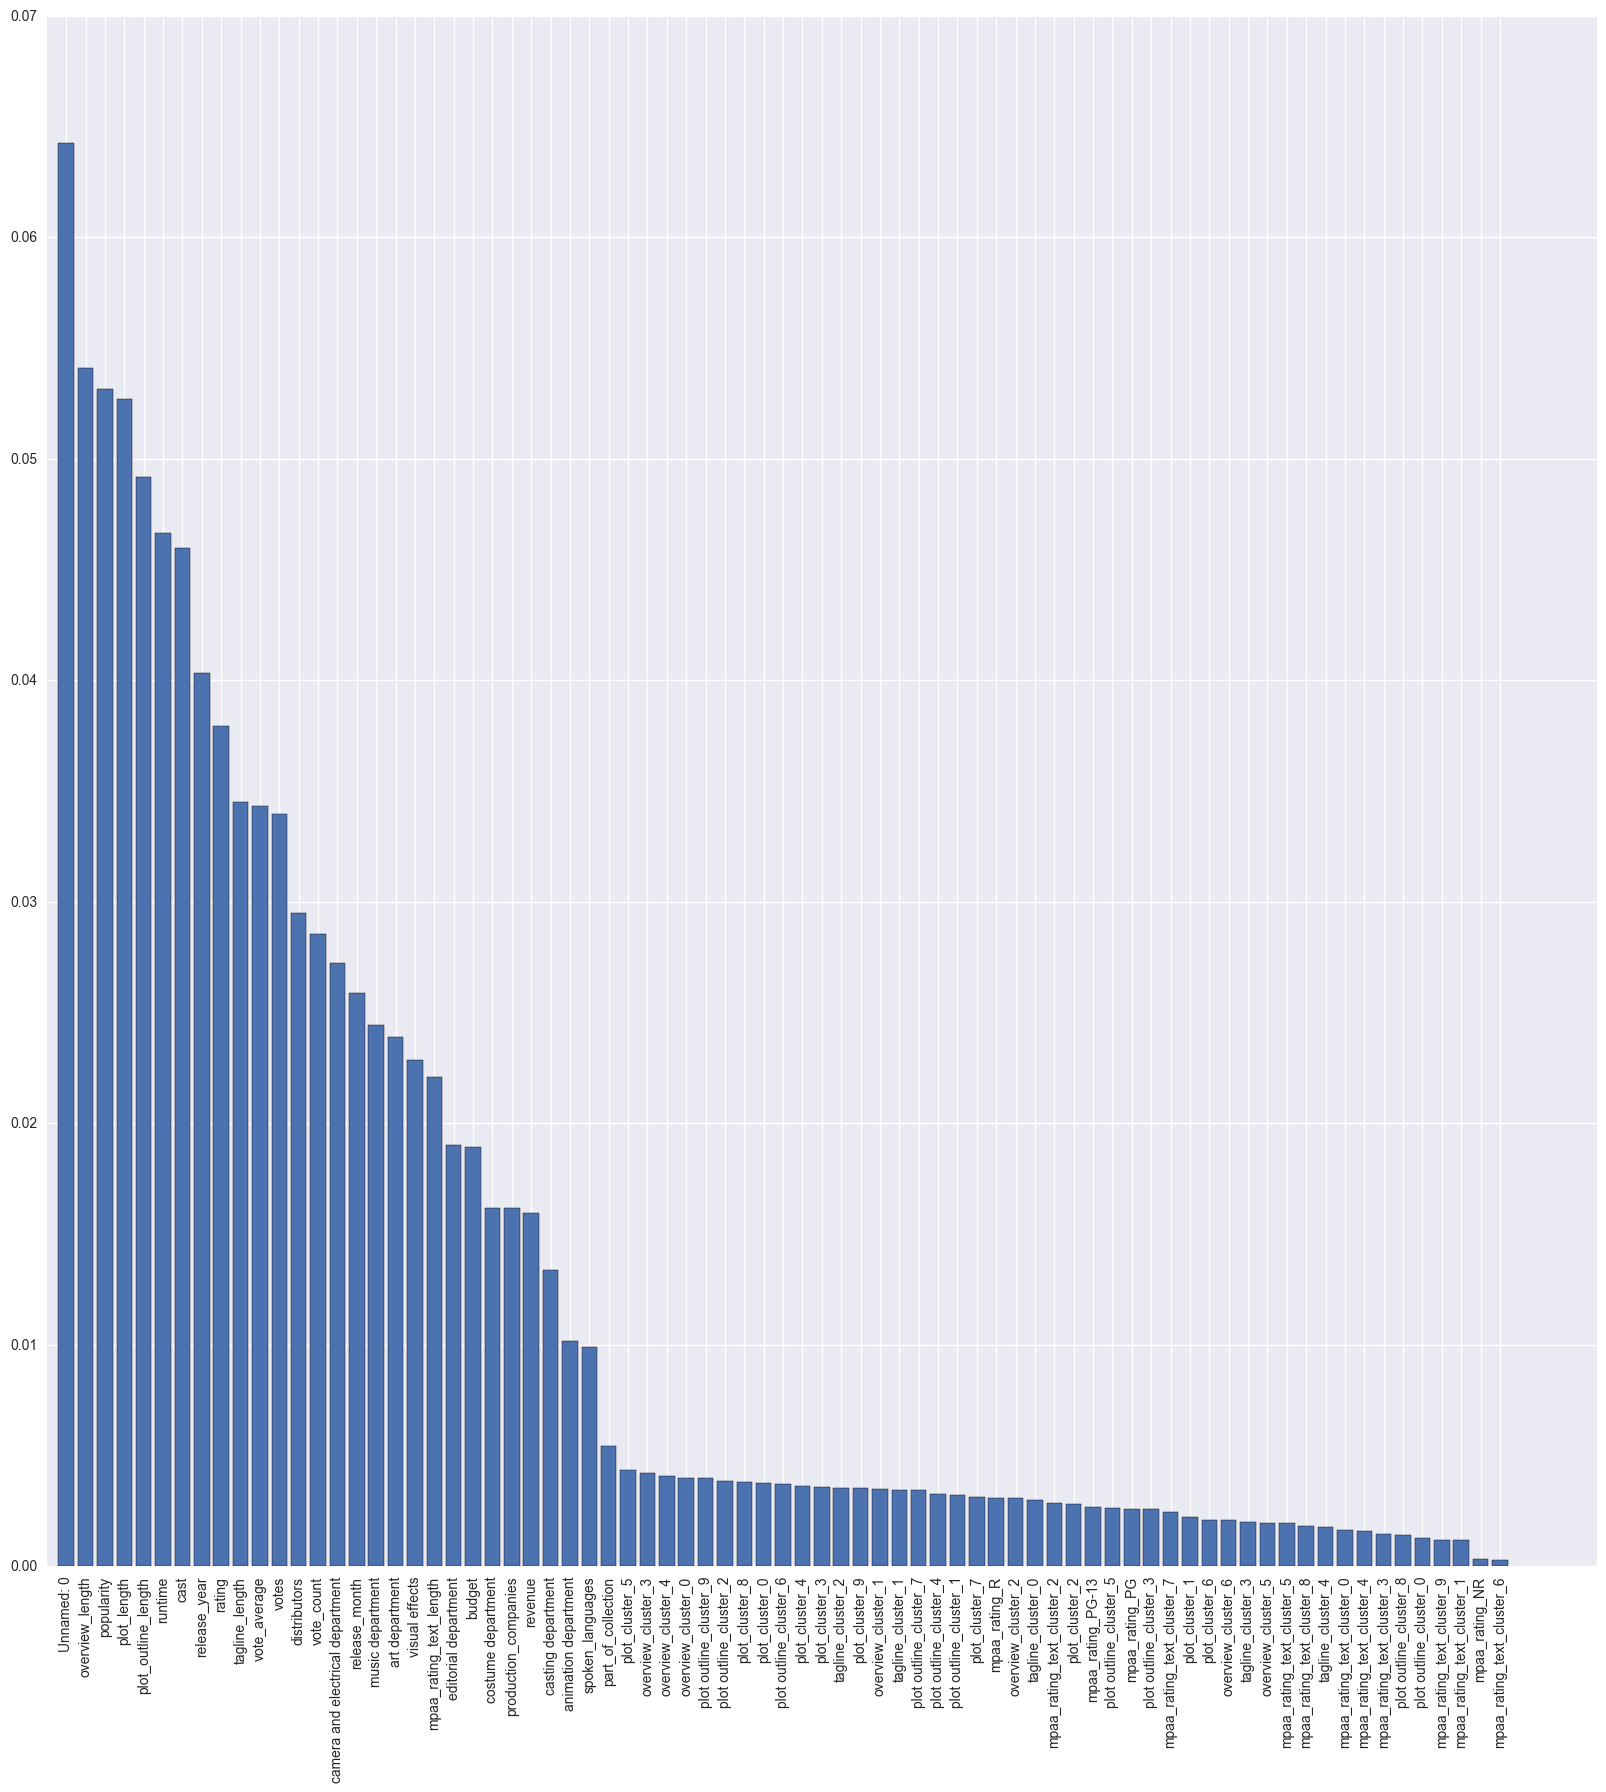

In [33]:
model_evaluation(X_train, y_train, xgb_model_final, 'Train')
model_evaluation(X_test, y_test, xgb_model_final, 'Test')
get_feature_importance(xgb_model_final, X_train)

# Compare Models

### RF Models

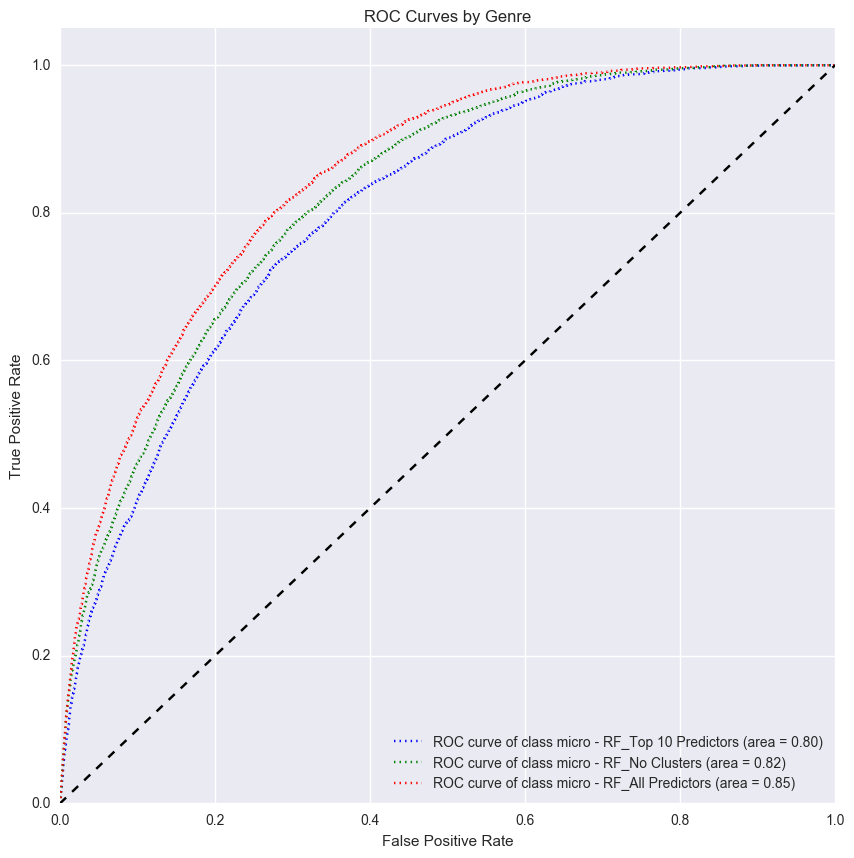

In [36]:
model_list_1 = [(rf_model_chosen, X_test), (rf_model_chosen_1, X_test_1), (rf_model_chosen_2, X_test_2)]
plot_roc(model_list_1, ['RF_All Predictors', 'RF_No Clusters', 'RF_Top 10 Predictors'], y_test)

### RF and XGB Model Comparison

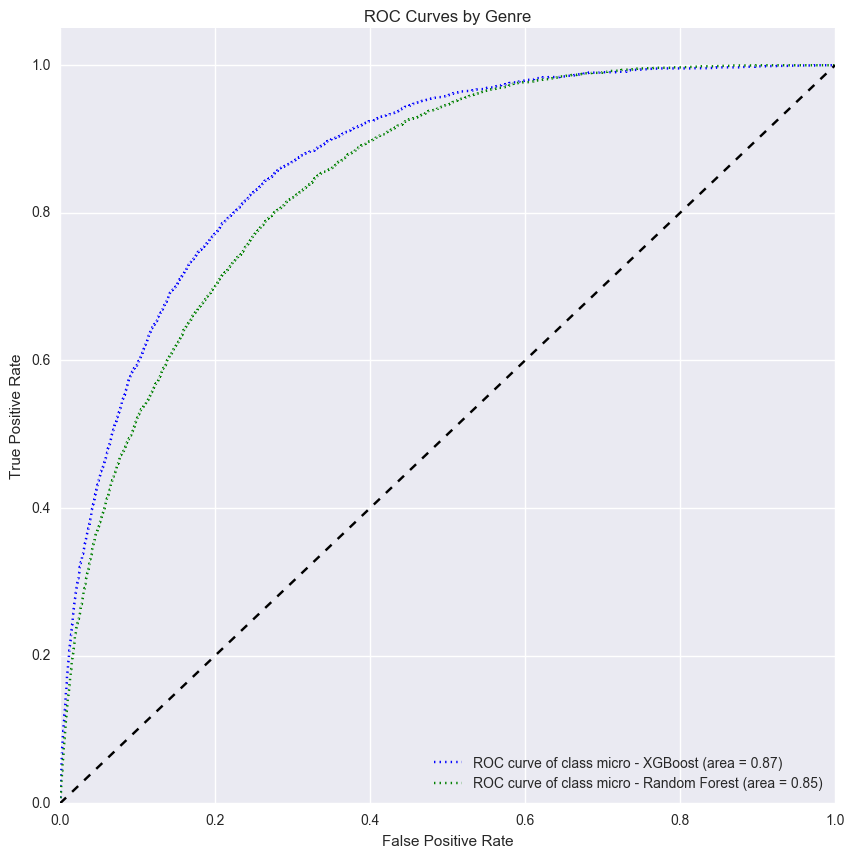

In [37]:
model_list_2 = [(rf_model_chosen, X_test), (xgb_model_final, X_test)]
plot_roc(model_list_2, ['Random Forest', 'XGBoost'], y_test)